In [60]:
import pyfits
import scipy.optimize as opt
import numpy as np
import pylab as plt
import rydlab
import pandas as pd
from fitting2d import Fit2d2Gaussian
import os
from lmfit import Model
pd.options.display.max_colwidth = 120

import matplotlib as mpl
mpl.rc('image', cmap='afmhot')

variables = np.loadtxt( '2019-06-05_variables.dat' )[:,1]
N = len(variables)
file_date = '2019-06-05'
path = 'A:/Projekte - Projects/2019_IEI/June/27'
folders = rydlab.analyze_folder(path,filter=0)
folders

Name  Valid
0                  A:/Projekte - Projects/2019_IEI/June/27\AutlerTownes   True
1                 A:/Projekte - Projects/2019_IEI/June/27\AutlerTownes2   True
2                 A:/Projekte - Projects/2019_IEI/June/27\AutlerTownes3   True
3  A:/Projekte - Projects/2019_IEI/June/27\AutlerTownes_averaged_images  False

In [76]:
path=folders.Name[3]

os.chdir(path)

print(os.getcwd())

def fitsopen(n):
    if n<10:
        hdulist = pyfits.open(file_date+str("_")+str(0)+str(n)+'.fts')
    else:
        hdulist = pyfits.open(file_date+str("_")+str(n)+'.fts')

    data=np.zeros((90,400))

    for y in range(10,100):
        for x in range(10,410):
            if hdulist[0].data[
                0,y,x]>hdulist[0].data[2,y,x] and hdulist[0].data[1,y,x]>hdulist[0].data[2,y,x]:
                data[y-10,x-10]=-np.log((hdulist[0].data[0,y,x]-hdulist[0].data[2,y,x])/(hdulist[0].data[1,y,x]-hdulist[0].data[2,y,x]))
            else:
                data[y-10,x-10]=-np.log(hdulist[0].data[2,y,x])
    hdulist.close()
    return data

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                        + c*((y-yo)**2)))
    return g.flatten()


def two_Gaussian(xy_mesh, amplitude1, xo1, yo1, sigma_x1, sigma_y1, theta1, amplitude2, xo2, yo2, sigma_x2, sigma_y2, theta2, offset):
    (x, y) = xy_mesh
    xo1 = float(xo1)
    yo1 = float(yo1)
    xo2 = float(xo2)
    yo2 = float(yo2)

    a1 = (np.cos(theta1)**2)/(2*sigma_x1**2) + (np.sin(theta1)**2)/(2*sigma_y1**2)
    b1 = -(np.sin(2*theta1))/(4*sigma_x1**2) + (np.sin(2*theta1))/(4*sigma_y1**2)
    c1 = (np.sin(theta1)**2)/(2*sigma_x1**2) + (np.cos(theta1)**2)/(2*sigma_y1**2)
    a2 = (np.cos(theta2)**2)/(2*sigma_x2**2) + (np.sin(theta2)**2)/(2*sigma_y2**2)
    b2 = -(np.sin(2*theta2))/(4*sigma_x2**2) + (np.sin(2*theta2))/(4*sigma_y2**2)
    c2 = (np.sin(theta2)**2)/(2*sigma_x2**2) + (np.cos(theta2)**2)/(2*sigma_y2**2)

    g = offset + amplitude1*np.exp( - (a1*((x-xo1)**2) + 2*b1*(x-xo1)*(y-yo1) + c1*((y-yo1)**2))) + amplitude2*np.exp( - (a2*((x-xo2)**2) + 2*b2*(x-xo2)*(y-yo2) + c2*((y-yo2)**2)))

    return g.flatten()

def fitsopen_bg(n,bg):
    hdulist = pyfits.open(file_date+str("_")+str(1).zfill(2)+'.fts')
    images = hdulist[0].data
    no_absorb = images[0]
    absorb = images[1]
    div = (no_absorb-bg)/(absorb-bg)
    div = div[10:100,10:410]
    div = -np.log(div)
    return div

def make_background(N):
    list_bg=list()
    for n in range(0,N):
        hdulist = pyfits.open(file_date+str("_")+str(1).zfill(2)+'.fts')
        list_bg.append(hdulist[0].data[2])
    bg = np.array(list_bg).mean(axis=0)
    return bg
        

def lorentz(x_array,gamma,xoo,a,o):
    xoo = float(xoo)
    gamma = float(gamma)
    x=x_array
    #print(x)
    #print(type(x))
    #l=gamma/((2*np.pi)((x-xoo)**2 + (gamma/2)**2))
    l=a*gamma/( (x-xoo)**2 + (gamma/2)**2 )+o
    #print(l)
    #print(type(l))
    return l#/(2*np.pi)

model_twoG = Model(two_Gaussian)
from lmfit import Parameters
params = Parameters()

params = model_twoG.make_params()

# cloud distribution
params.add('amplitude1',value=0.0)
params.add('yo1',value=160,min=140,max=180)
params.add('xo1',value=45,min=30,max=60)
params.add('sigma_x1',value=5,min=30,max=200)
params.add('sigma_y1',value=5,min=30,max=200)
params.add('theta1',value=0,min=0,max=np.pi)

# EIT/Autler-Townes-dip
params.add('amplitude2',value=0.00)
params.add('yo2',value=171.2,min=169,max=173)
params.add('xo2',value=48.1,min=46,max=50)
params.add('sigma_x2',value=10,min=3,max=15)
params.add('sigma_y2',value=10,min=3,max=15)
params.add('theta2',value=0,min=0,max=np.pi)

# offset
params.add('offset',value=0)

A:\Projekte - Projects\2019_IEI\June\27\AutlerTownes_averaged_images


C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning:

divide by zero encountered in log

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning:

invalid value encountered in log



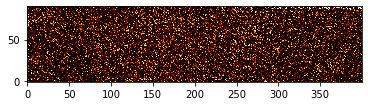

In [77]:
bg = make_background(N)
plt.imshow(fitsopen_bg(10,bg),origin='bottom',vmin=0, vmax=0.4)

In [81]:
image = fitsopen_bg(10,bg)
np.argwhere(np.isnan(image))

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning:

divide by zero encountered in log

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning:

invalid value encountered in log



array([[ 88, 337],
       [ 88, 371],
       [ 88, 375],
       [ 89, 253],
       [ 89, 267],
       [ 89, 280],
       [ 89, 290],
       [ 89, 291],
       [ 89, 303],
       [ 89, 305],
       [ 89, 306],
       [ 89, 308],
       [ 89, 313],
       [ 89, 319],
       [ 89, 338],
       [ 89, 354],
       [ 89, 356],
       [ 89, 374],
       [ 89, 378],
       [ 89, 382],
       [ 89, 391],
       [ 89, 394],
       [ 89, 395],
       [ 89, 399]], dtype=int64)

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\pyfits\util.py:899: UserWarning:

Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.



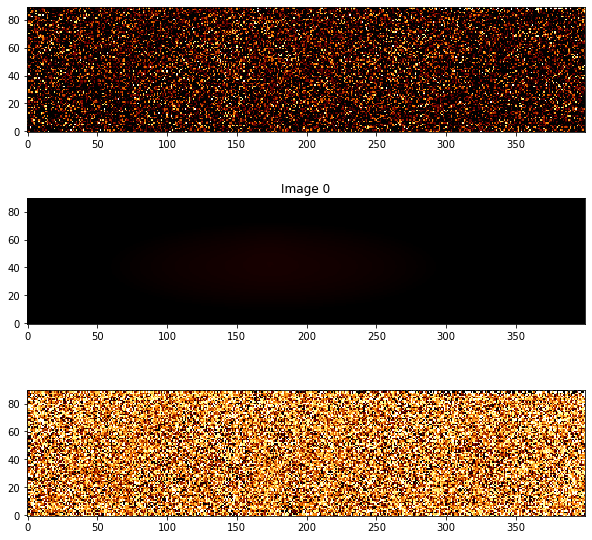

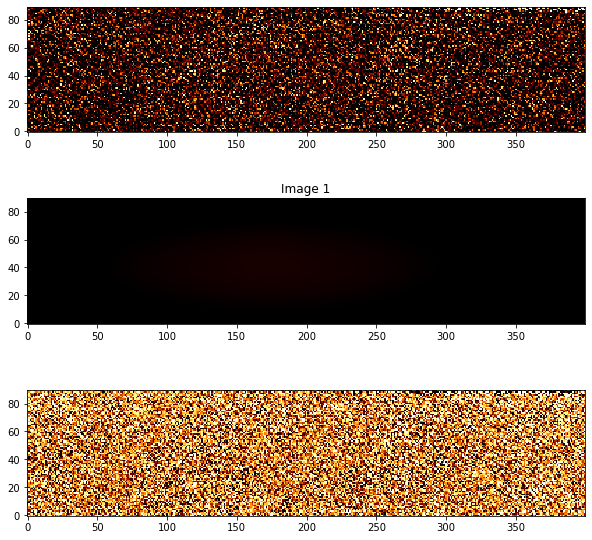

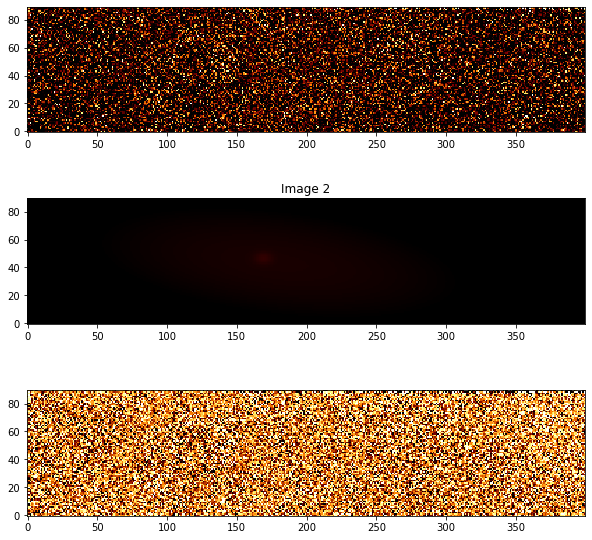

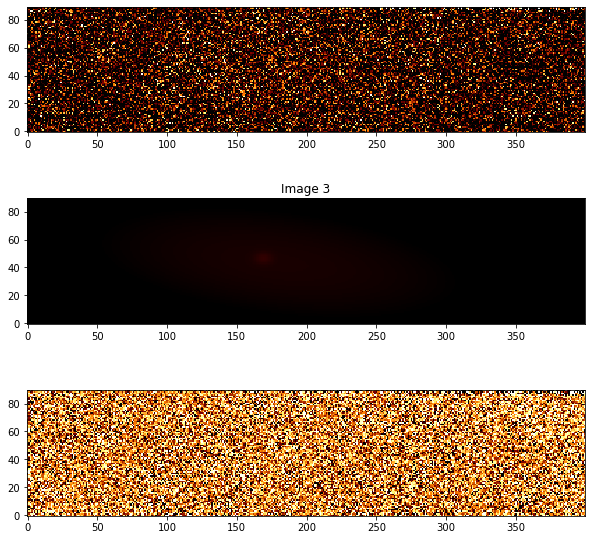

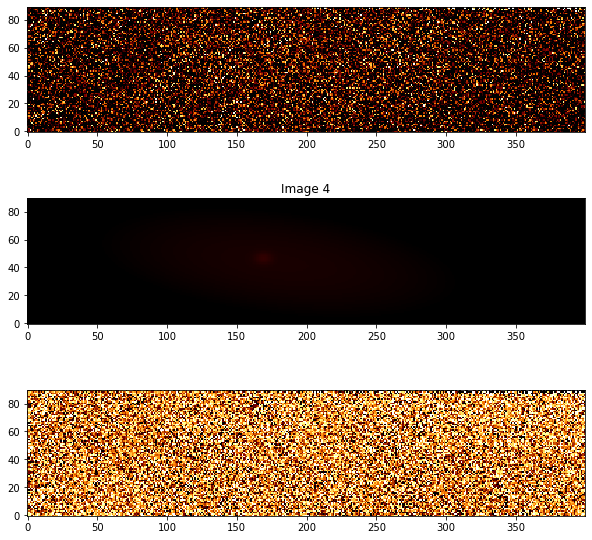

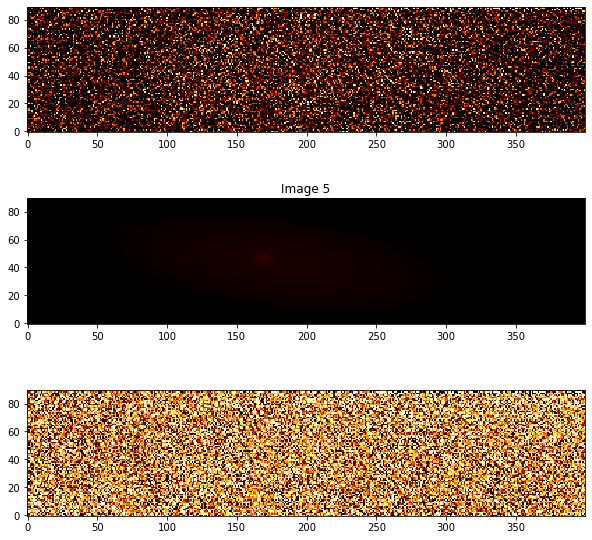

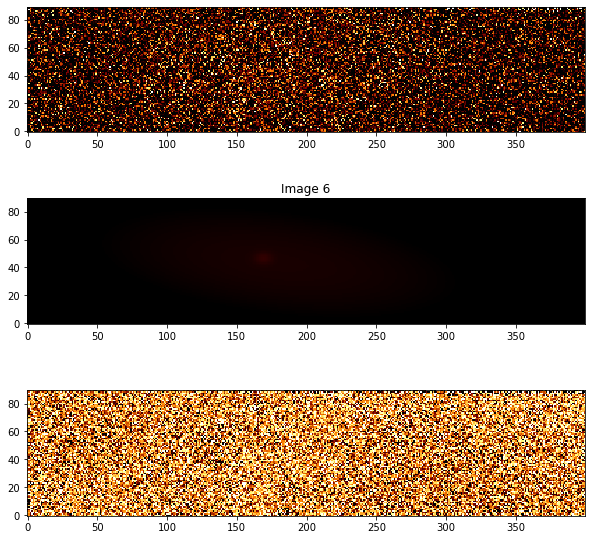

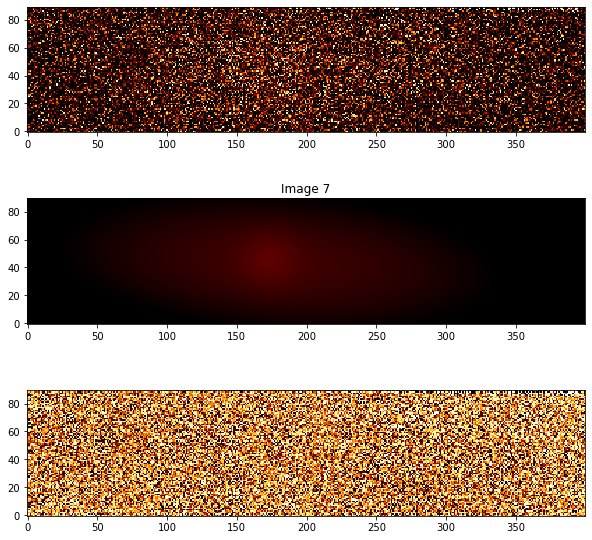

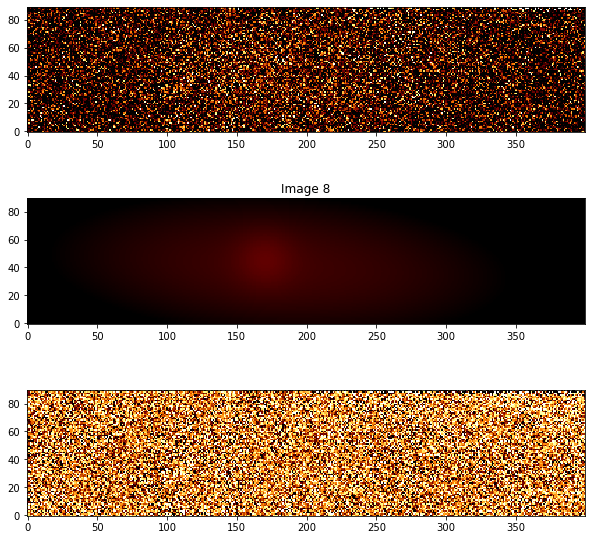

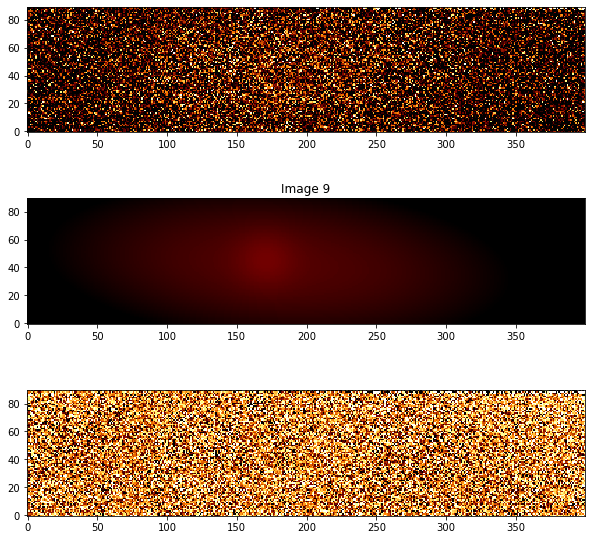

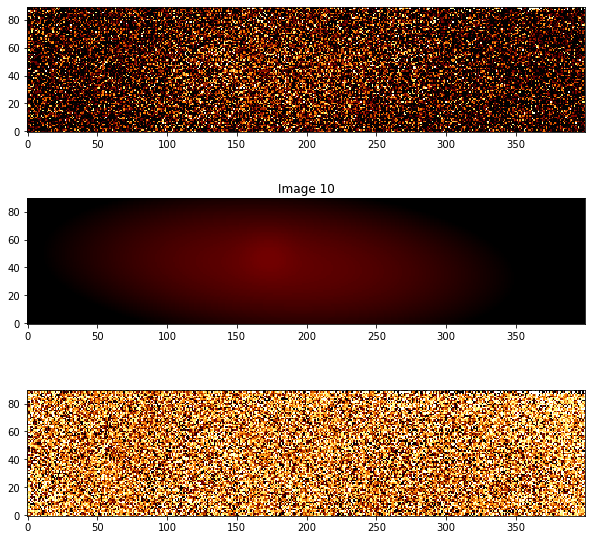

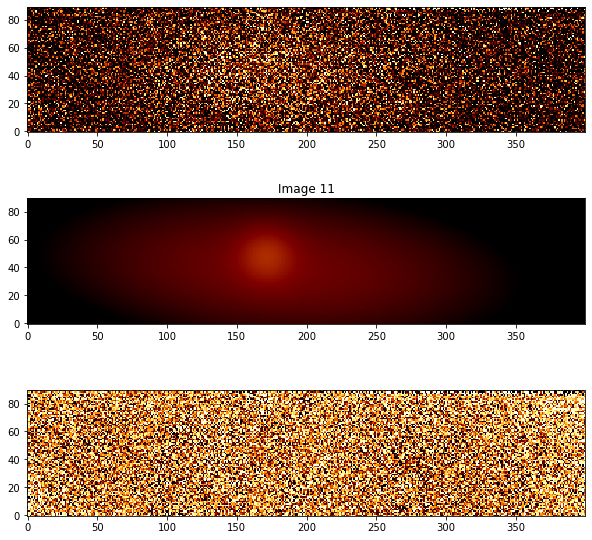

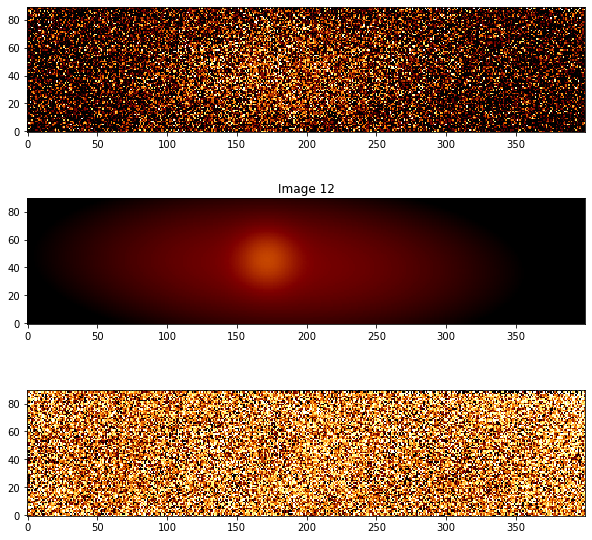

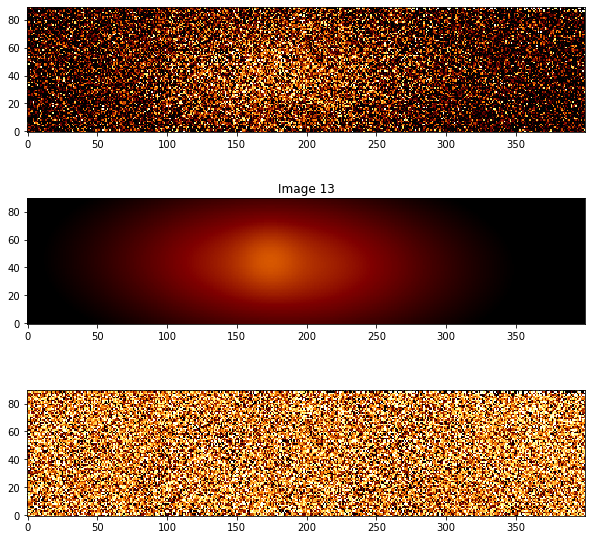

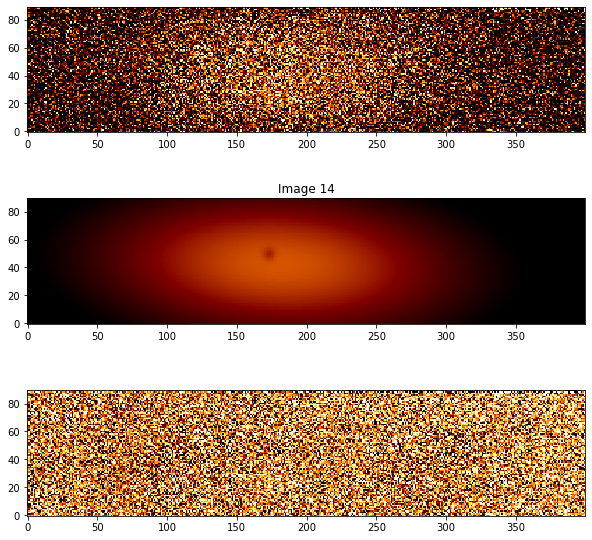

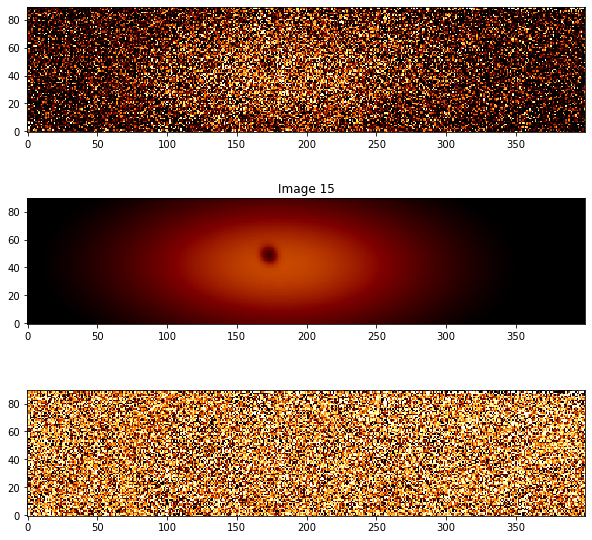

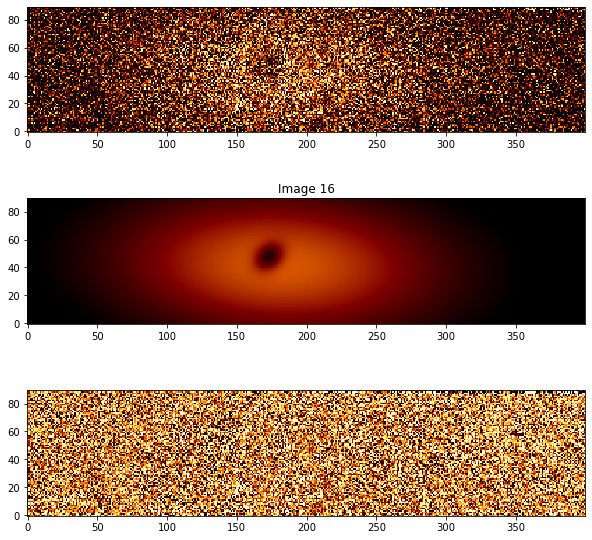

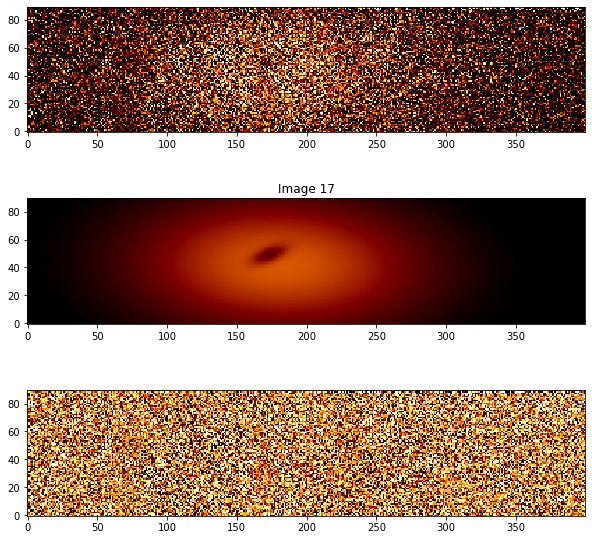

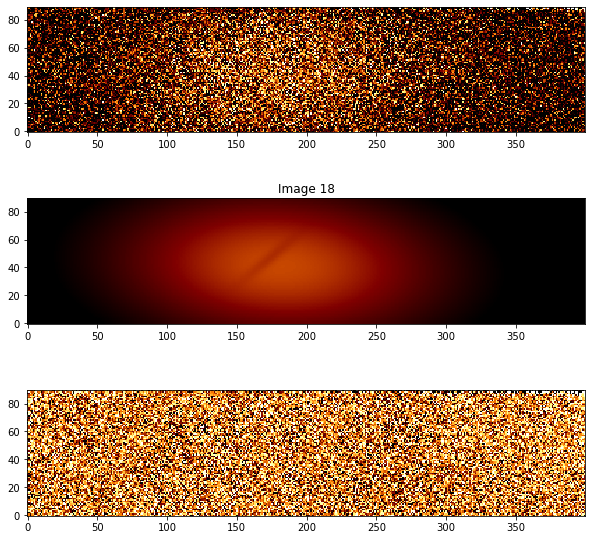

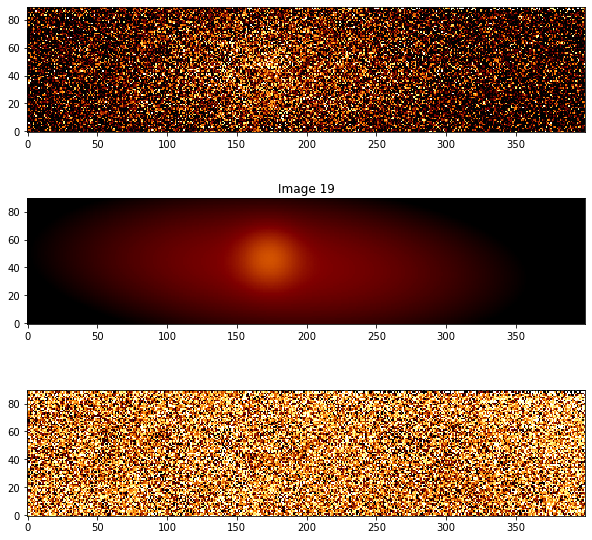

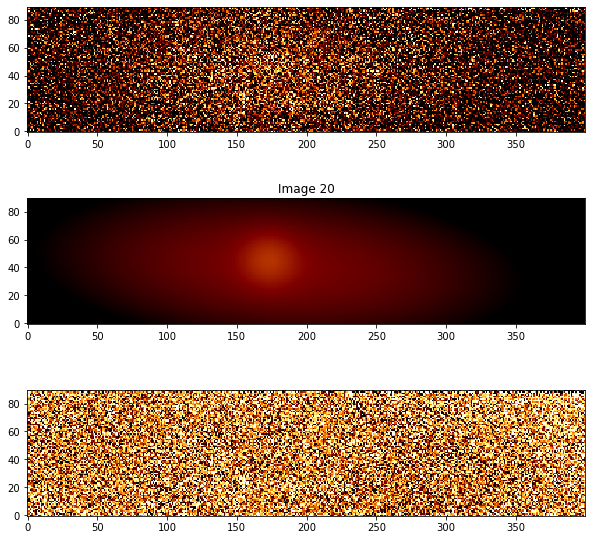

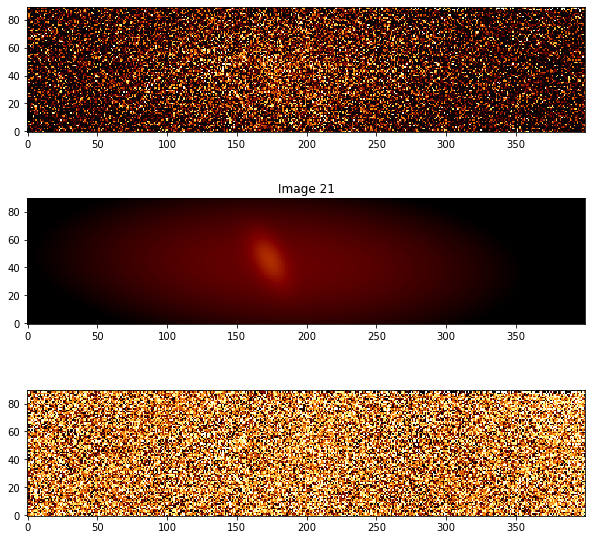

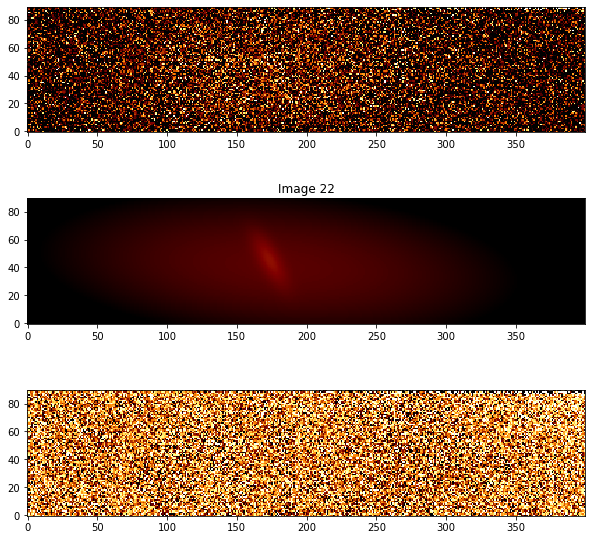

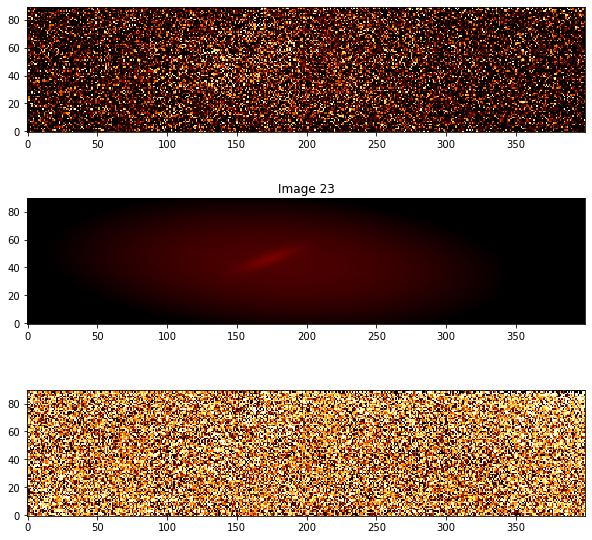

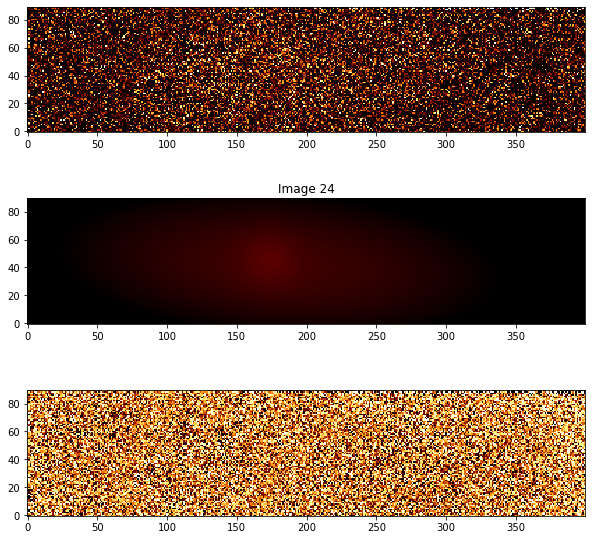

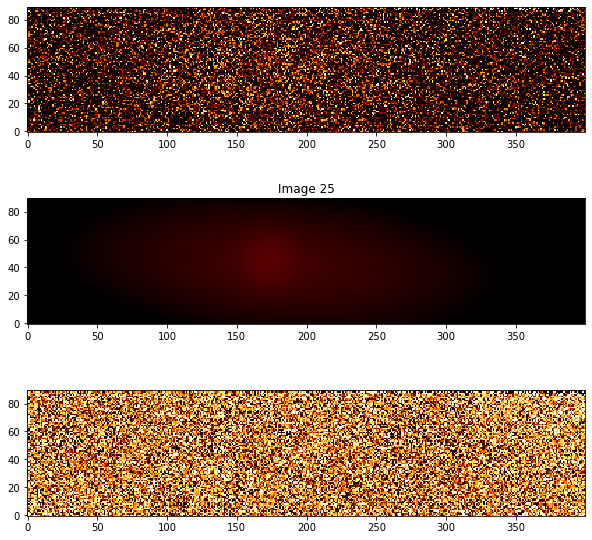

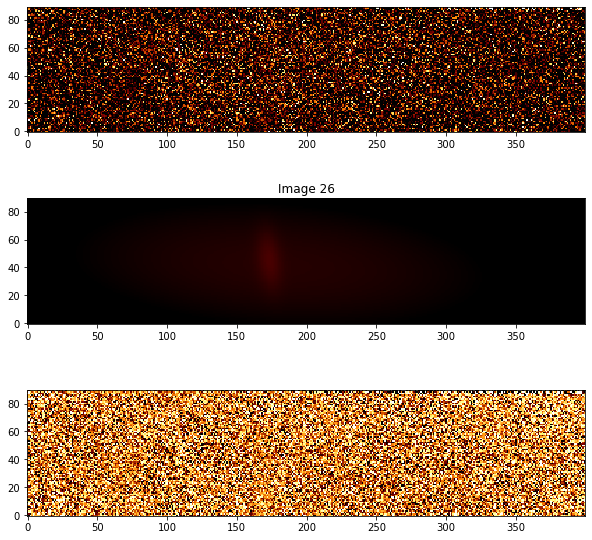

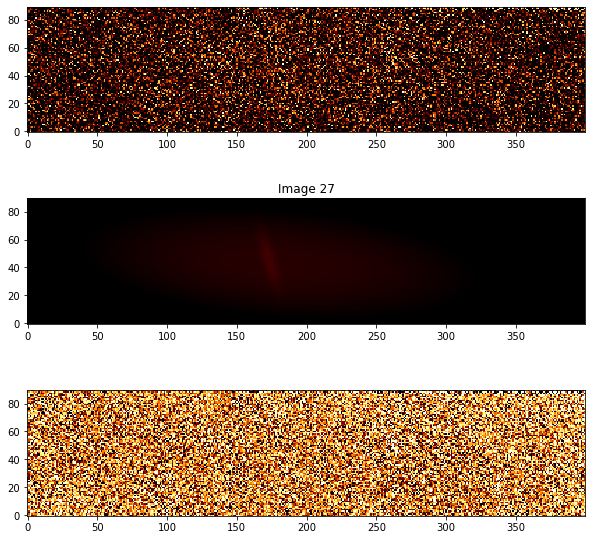

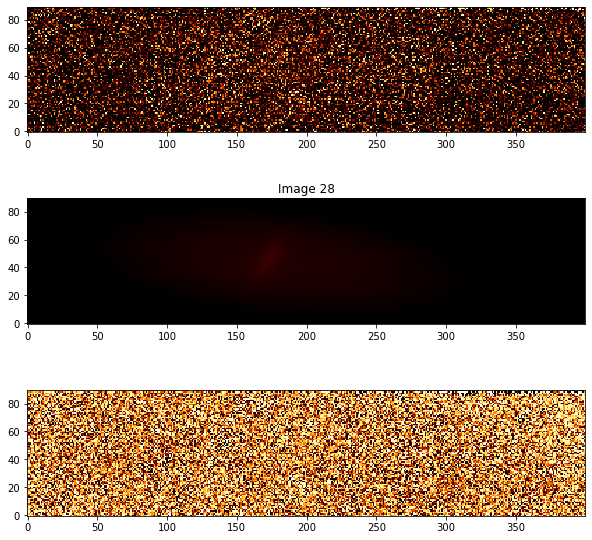

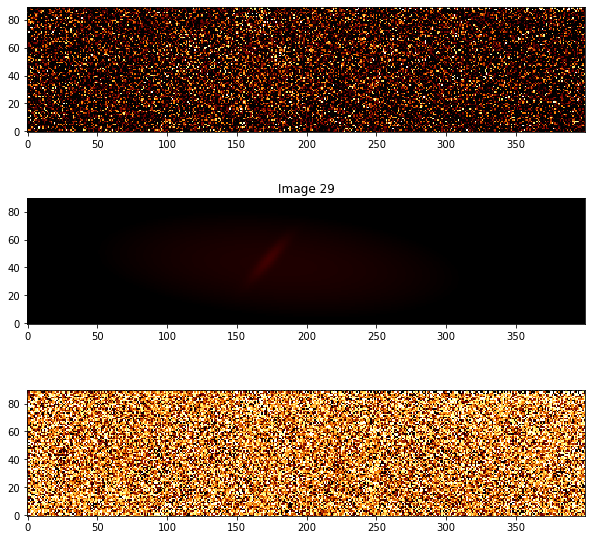

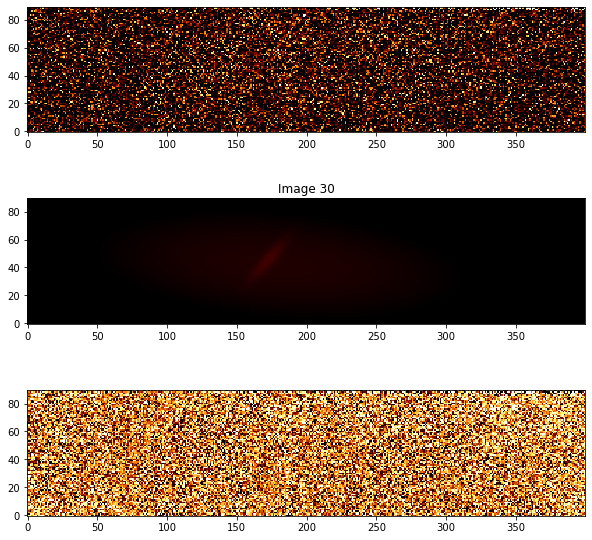

In [4]:

results=list()
for n in range(0,len(variables)):
    #print(n)
    image = fitsopen(n)
    shape = image.shape
    x,y = np.mgrid[0:shape[0],0:shape[1]]
    image_flat=image.flatten()    
    out = model_twoG.fit(image_flat,params,xy_mesh=(x,y))##method='Powel')
    fig,ax = plt.subplots(3,1,figsize=(10,10))
    results.append(out)
    params = out.params
    ax[0].imshow(image,
                 origin='bottom',vmin=0, vmax=0.4)
    ax[1].set_title('Image '+str(n))
    ax[1].imshow(out.best_fit.reshape(shape),
                 origin='bottom',vmin=0, vmax=0.4)
    ax[2].imshow((image-out.best_fit.reshape(shape)),
                 origin='bottom',vmin=-0.2, vmax=0.2)
    plt.show()

In [43]:
p = results[0].params['yo1']



def AutlerTownesIm(Dp,Dp0=0,Dc=0,g31=0.3,g21=0.1,Wc=0.5,y0=0.2,y1=0,offset=0):
    """
    Imaginary Part of the first order susceptibility
    
    in the ladder scheme:
    index 1 ~ ground state
    index 2 ~ excited state
    index 3 ~ intermediate state
    
    
    """
    
    Dp = Dp-Dp0
    d = Dp-Dc
    return offset+(y0+y1*Dp)*( 8*d**2 * g31 + 2*g21*(abs(Wc)**2 + g21*g31)) / abs(abs(Wc)**2 + (g31+1.j*2*Dp)*(g21+1.j*2*d))**2

model_AT = Model(AutlerTownesIm)
params = model_AT.make_params()
params.add('Dc',value=0.1)#,vary=False)
params.add('g31',value=6,min=4,max=10)
params.add('g21',value=0.001,min=0)
params.add('Wc',value=1,min=0)
params.add('y0',value=0.8)
params.add('y1',value=0)
params.add('offset',value=0.1)

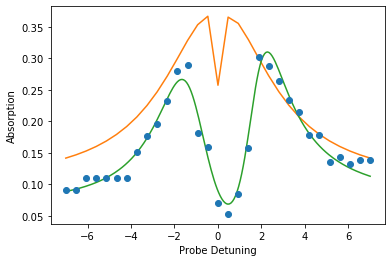

In [44]:
y = [1-np.e**(-r.params['amplitude2'].value-r.params['amplitude1'].value) for r in results]
#yerr = np.sqrt([ (r.params['amplitude2'].stderr/r.params['amplitude2'].value)**2+(r.params['amplitude1'].stderr/r.params['amplitude1'].value)**2 
#        if (r.params['amplitude2'].stderr is not None) & (r.params['amplitude2'].stderr is not None) else 0 for r in results ])

yerr = np.sqrt([ (r.params['amplitude2'].stderr)**2+(r.params['amplitude1'].stderr)**2 + (r.params['offset'].stderr)**2 if (r.params['amplitude2'].stderr is not None) & (r.params['amplitude2'].stderr is not None) & (r.params['offset'].stderr is not None) else 0 for r in results ])
#yerr=np.array(yerr)*y
plt.errorbar(variables,y,yerr=yerr,marker='o',linestyle='')

out = model_AT.fit(y,params=params,Dp=variables )

#popt1, pcov1 = opt.curve_fit(lorentz,variables,y, p0=(2.5,1.,-0.13,0.1))

#plt.plot(variables,lorentz(np.array(variables), *popt1))
v = np.linspace(min(variables),max(variables),200)
plt.plot(variables,out.init_fit)
plt.plot(v,model_AT.eval(out.params,Dp=v))
plt.xlabel("Probe Detuning")
plt.ylabel("Absorption")
plt.savefig("AT.svg")
plt.show()
#n = np.argmax(-np.array(valdiv))

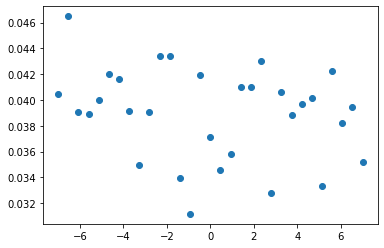

In [38]:
out.result
y = [ r.redchi for r in results]

plt.plot(variables,y,marker='o',linestyle='')

#y = [ r. for r in results]

#plt.plot(variables,y,marker='o',linestyle='')

In [45]:
out